# combined and simultaneous fits

It is possible to use `sasmodels` to fit scattering data for a single system even if data was collected across two instruments. The approach is to create a `bumps` MultiFitProblem that simultaneously fits multiple Experiments (one for each dataset) that shares common Parameter objects.

In [34]:
from bumps.names import Parameter, inf
from bumps.fitters import fit

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

import sasmodels
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment

import bumps

# uncomment and edit line below to add path to the sasview source code
# sys.path.append("/path/to/sasview/src")
import sas

Let's use an example where we collected data for a sample using both SANS and USANS instrumentation. In this case, the USANS data has already been 'de-smeared' and we see good aggregment across the full range of q-values.

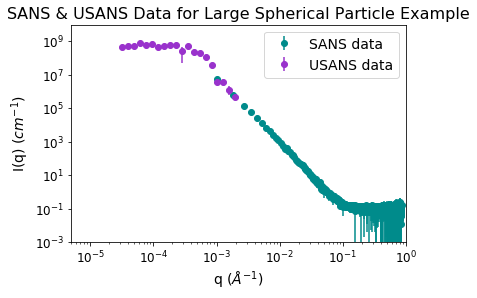

In [35]:
data_np = np.loadtxt('../example_data/sphere2_sans.csv',delimiter=',')
mask = np.where(data_np[:,1]>0)[0] # removing points that may be below zero due to noise
sans_data = sasmodels.data.Data1D(x=data_np[mask,0], y=data_np[mask,1], dy=data_np[mask,2])

data_np = np.loadtxt('../example_data/sphere2_usans.csv',delimiter=',')
mask = np.where(data_np[:,1]>0)[0] # removing points that may be below zero due to noise
usans_data = sasmodels.data.Data1D(x=data_np[mask,0], y=data_np[mask,1], dy=data_np[mask,2])

plt.errorbar(sans_data.x, sans_data.y, yerr=sans_data.dy, fmt='o', color='darkcyan', label='SANS data')
plt.errorbar(usans_data.x, usans_data.y, yerr=usans_data.dy, fmt='o', color='darkorchid', label='USANS data')

# x-axis
plt.xlim(5e-6,1e0)
plt.xscale('log')
plt.xlabel('q ($\AA^{-1}$)',fontsize=14)
plt.xticks(fontsize=12)

# y-axis
plt.ylim(1e-3,1e10)
plt.yscale('log')
plt.ylabel('I(q) ($cm^{-1}$)',fontsize=14)
plt.yticks(fontsize=12)

plt.title('SANS & USANS Data for Large Spherical Particle Example',fontsize=16)
plt.legend(fontsize=14)

plt.show()

We start by setting up the kernel and model as we normally would for a single dataset:

In [36]:
kernel = sasmodels.core.load_model("sphere")

scale = Parameter(0.8, name='scale').range(0,1) # setting our fitting range to (0,1)
background = Parameter(0.01, name='incoherent background').range(0,1)

# scattering length densities for our scattering particles and solvent
sld = Parameter(0.728, name='sld')
sld_solvent = Parameter(5.238, name='sld solvent')

radius = Parameter(4000, limits=(0,inf), name='radius').range(0,5000)
radius_pd = Parameter(0.2, limits=(0,inf), name='radius')
radius_pd_type = 'lognormal'

model = Model(model=kernel,
             scale=scale,
             background=background,
             sld=sld,
             sld_solvent=sld_solvent,
             radius=radius,
             radius_pd=radius_pd,
             radius_pd_type=radius_pd_type
             )

We will now set up multiple experiments, one for each dataset and combine them into a single MultiFitProblem:

final chisq 10.0500(35)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                   incoherent background 0.100277(55)    0.100277(17)   
                                  radius 3998.12(22)     3998.119(71)   
                                   scale 0.9137(14)      0.91367(44)    


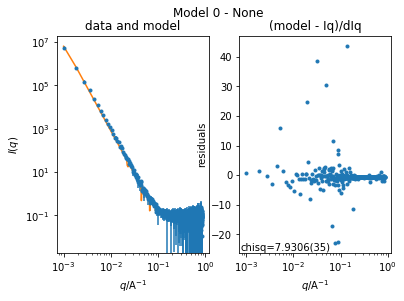

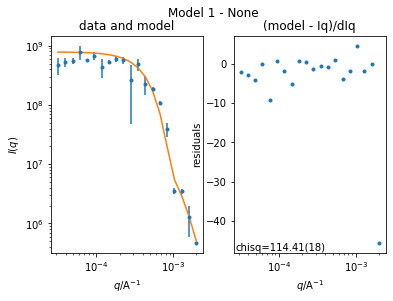

In [37]:
sans_experiment = sasmodels.bumps_model.Experiment(data=sans_data, model=model)
usans_experiment = sasmodels.bumps_model.Experiment(data=usans_data, model=model)
experiment = [sans_experiment, usans_experiment]

problem = bumps.fitproblem.FitProblem(experiment)
results = bumps.fitters.fit(problem, method='lm', verbose=True)
problem.plot()

Because each fit experiment utilized the same instances of our Parameter objects, these parameters can be held constant across the two datasets. This could also be helpful if you have datasets for different samples, but you know that a single parameter is common between them, such as the volume fraction (scale) or particle size. It's possible to use as many common or distinct Parameters as desired, however, remember that as your fit problem grows, so will computational expense of the fit.

To extend this example, let's consider a SANS and USANS dataset in which the USANS data is still in the smeared form. Here, the data will seem "disconnected" in the mid-q range, however, the model can mathematically account for the effect of smearing and still fit a common particle size between the models.

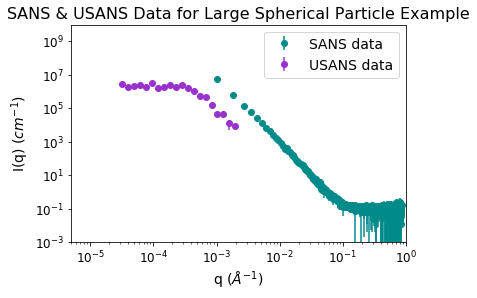

In [38]:
data_np = np.loadtxt('../example_data/sphere2_sans.csv',delimiter=',')
mask = np.where(data_np[:,1]>0)[0] # removing points that may be below zero due to noise
sans_data = sasmodels.data.Data1D(x=data_np[mask,0], y=data_np[mask,1], dy=data_np[mask,2])

data_np = np.loadtxt('../example_data/sphere2_usans_smearing.csv',delimiter=',')
mask = np.where(data_np[:,1]>0)[0] # removing points that may be below zero due to noise
usans_data = sasmodels.data.Data1D(x=data_np[mask,0], y=data_np[mask,1], dy=data_np[mask,2])

plt.errorbar(sans_data.x, sans_data.y, yerr=sans_data.dy, fmt='o', color='darkcyan', label='SANS data')
plt.errorbar(usans_data.x, usans_data.y, yerr=usans_data.dy, fmt='o', color='darkorchid', label='USANS data')

# x-axis
plt.xlim(5e-6,1e0)
plt.xscale('log')
plt.xlabel('q ($\AA^{-1}$)',fontsize=14)
plt.xticks(fontsize=12)

# y-axis
plt.ylim(1e-3,1e10)
plt.yscale('log')
plt.ylabel('I(q) ($cm^{-1}$)',fontsize=14)
plt.yticks(fontsize=12)

plt.title('SANS & USANS Data for Large Spherical Particle Example',fontsize=16)
plt.legend(fontsize=14)

plt.show()

final chisq 1505.3763(35)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                   incoherent background 0.032490(56)    0.0324895(14)  
                                  radius 3996.13(19)     3996.1303(50)  
                                   scale 0.9999147568(33) 0.999914756832(85)


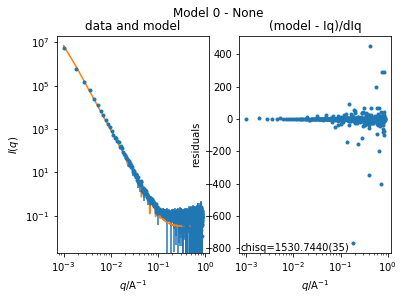

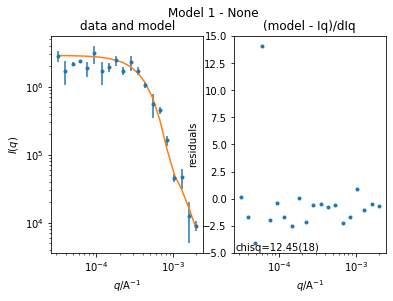

In [39]:
kernel = sasmodels.core.load_model("sphere")

scale = Parameter(0.8, name='scale').range(0,1) # setting our fitting range to (0,1)
background = Parameter(0.01, name='incoherent background').range(0,1)

# scattering length densities for our scattering particles and solvent
sld = Parameter(0.728, name='sld')
sld_solvent = Parameter(5.238, name='sld solvent')

radius = Parameter(4000, limits=(0,inf), name='radius').range(0,5000)
radius_pd = Parameter(0.2, limits=(0,inf), name='radius')
radius_pd_type = 'lognormal'

model = Model(model=kernel,
             scale=scale,
             background=background,
             sld=sld,
             sld_solvent=sld_solvent,
             radius=radius,
             radius_pd=radius_pd,
             radius_pd_type=radius_pd_type
             )

sans_experiment = sasmodels.bumps_model.Experiment(data=sans_data, model=model)

usans_experiment = sasmodels.bumps_model.Experiment(data=usans_data, model=model)
smearing = sasmodels.resolution.Slit1D(usans_data.x, 0.117)
usans_experiment.resolution = smearing

experiment = [sans_experiment, usans_experiment]

problem = bumps.fitproblem.FitProblem(experiment)
results = bumps.fitters.fit(problem, method='lm', verbose=True)
problem.plot()

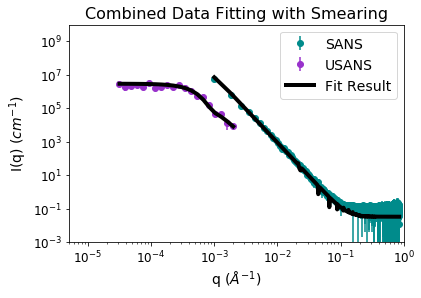

In [40]:
plt.errorbar(sans_data.x, sans_data.y, yerr=sans_data.dy, fmt='o', color='darkcyan', label='SANS')
plt.errorbar(usans_data.x, usans_data.y, yerr=usans_data.dy, fmt='o', color='darkorchid', label='USANS')

prob_list = [result for result in problem.models]
plt.errorbar(sans_data.x, prob_list[0].fitness.theory(), fmt='-', color='black', label='Fit Result', linewidth=4)
plt.errorbar(usans_data.x, prob_list[1].fitness.theory(), fmt='-', color='black', linewidth=4)


# x-axis
plt.xlim(5e-6,1e0)
plt.xscale('log')
plt.xlabel('q ($\AA^{-1}$)',fontsize=14)
plt.xticks(fontsize=12)

# y-axis
plt.ylim(1e-3,1e10)
plt.yscale('log')
plt.ylabel('I(q) ($cm^{-1}$)',fontsize=14)
plt.yticks(fontsize=12)

plt.title('Combined Data Fitting with Smearing',fontsize=16)
plt.legend(fontsize=14)

plt.show()